In [256]:
# Importanweisungen

import numpy as np
import statistics as stat
import scipy as sci
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
from matplotlib import colors as mcolors
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp 
import uncertainties.umath as umath
unv=unp.nominal_values
usd=unp.std_devs

In [257]:
# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 14
fig_labelsize = 12
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [258]:
# mathe Funktionen

def mean(n):
    # find the mean value and add uncertainties
    k = np.mean(n)
    err = stat.variance(unv(n))
    return unc.ufloat(unv(k), math.sqrt(usd(k)**2 + err))

In [259]:
# allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x 
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * np.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

def gauss(x, x0, A, d, y0):
    return A * np.exp(-(x - x0)**2 / 2 / d**2) + y0

def exponential(x, c, y0):
    return np.exp(c * x) * y0

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit 

# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

In [260]:
# gibt Daten fuer LaTeX bereitgestellt aus

def latex_printValue(val, file):
    if hasattr(val, "__iter__"):
        i = 1
        for v in val:
            latex_printValue(v, file+"_"+str(i))
            i += 1
    else:
        f = open('data/%s.txt' % file, 'w')
        f.write(str(val).replace('/', ''))
        f.close()

In [261]:
# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin 
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad

In [262]:
# import der messwerte

unc_spannung = 0.01 / 2 / np.sqrt(3) # Voltmeter; digital in Volt(20V)
unc_polariseur = 1 / 2 / np.sqrt(6) # Winkel polariseur; analog in Grad
unc_standbein = 1 / 2 / np.sqrt(6) # Winkel standbein von glas; analog in Grad
unc_lambda = 2 / 2 / np.sqrt(6) # Winkel lambda/2 platte; analog in Grad
unc_bragg = 10 / 2 / np.sqrt(6) # Braggwinkel abgelesen aus Diagramm

def converter(data):
    try:
        return float(s if len(s) > 0 else 0)
    except:
        return data
        
con = {}
for i in range(50):
    con[i] = converter

laser = unc.ufloat(106, unc_polariseur)
    
data = np.loadtxt("messung/polLaser.csv", skiprows = 1, delimiter = ",")
polLaser = (unp.uarray(data[:,0], unc_polariseur), unp.uarray(data[:,1], unc_spannung))

data = np.loadtxt("messung/polLambda.csv", skiprows = 1, delimiter = ",")
polLambda = (unp.uarray(data[:,0], unc_lambda) - laser, unp.uarray(data[:,1], unc_polariseur) - laser)

data = np.loadtxt("messung/glasReflection.csv", skiprows = 1, delimiter = ",")
reflection = (unp.uarray(data[:,0], unc_standbein), unp.uarray(data[:,1], unc_spannung))

data = np.loadtxt("messung/konzentration.csv", skiprows = 1, usecols = (1,2), delimiter = ",")
konzentration = (data[:,0], unp.uarray(data[:,1], unc_polariseur) + 90)

U = unc.ufloat(43, unc_polariseur) + 90
phi_bragg = unc.ufloat(50, unc_bragg)

In [263]:
# Rechnung polLaser

def cos2(phi, k, phi0, A):
    return A * np.cos(k * phi - phi0)**2

xdata, ydata = polLaser[0]*grad, polLaser[1]
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), cos2, yerr = usd(ydata), p0 = [1, unv(laser)*grad, 1.670])
laserFit = unp.uarray(pfit, perr)
latex_printValue(laserFit[1] * rad, "laserPolarisationFit")

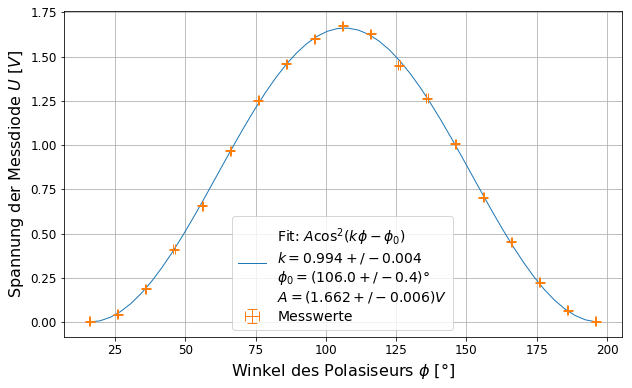

In [264]:
# Diagramm polLaser

fig=plt.figure(figsize=fig_size)
    
xdata, ydata = polLaser
xrange = np.linspace(-90, 90) + unv(laser)
plt.plot(xrange, cos2(xrange*grad, *unv(laserFit)), linewidth=1, label = 'Fit: $A \cos^2(k\phi - \phi_0)$\n$k = %s$\n$\phi_0 = (%s)°$\n$A = (%s)V$' % tuple(laserFit * (1,rad,1)))
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label='Messwerte')
    
# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Winkel des Polasiseurs $\phi$ [$°$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Spannung der Messdiode $U$ [$V$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/laserPolarisation.pdf")
plt.show()

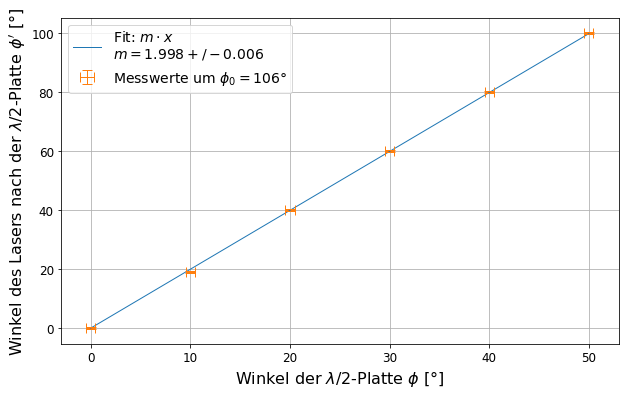

In [265]:
# Diagramm polLambda

fig=plt.figure(figsize=fig_size)

xdata, ydata = polLambda

pfit, perr = fit_curvefit(unv(xdata), unv(ydata), linear, yerr = usd(ydata), p0 = [2])
lambdaPlatte = unp.uarray(pfit, perr)

xrange = np.linspace(0,50)
fitData = (xrange, linear(xrange, *unv(lambdaPlatte)))
plt.plot(*fitData, linewidth=1, label = 'Fit: $m\cdot x$\n$m = %s$' % tuple(lambdaPlatte))

plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label='Messwerte um $\phi_0 = 106°$')
    
# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel(r"Winkel der $\lambda/2$-Platte $\phi$ [$°$]", {'fontsize':fig_legendsize+2})
plt.ylabel(r"Winkel des Lasers nach der $\lambda/2$-Platte $\phi'$ [$°$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/lambdaPolarisation.pdf")
plt.show()

In [266]:
# rechnung spiegel

kappa = np.array([phi_bragg, phi_bragg, phi_bragg])
n = umath.atan(phi_bragg)
latex_printValue(n, "n_spiegelGlas")

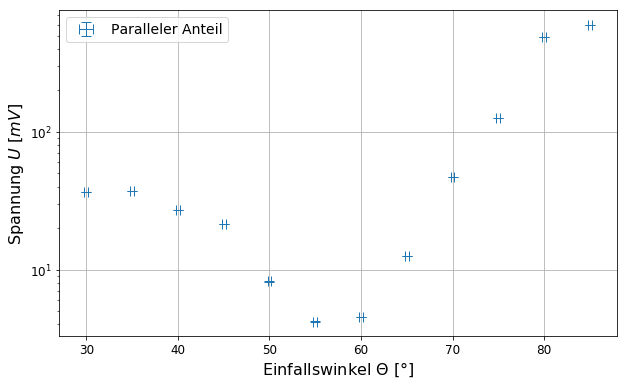

In [267]:
# diagramm spiegel

fig=plt.figure(figsize=fig_size)

(xdata, ydata) = reflection
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label = 'Paralleler Anteil')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.yscale('log')
plt.xlabel("Einfallswinkel $\Theta$ [$°$]", {'fontsize': fig_legendsize+2})
plt.ylabel("Spannung $U$ [$mV$]", {'fontsize':fig_legendsize+2})
plt.savefig("data/spiegel.pdf")
plt.show()

In [268]:
# rechnung konzentration

(xdata, ydata) = konzentration

pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [2, 101])
fit_konz = unp.uarray(pfit, perr)

U_konz = (U - fit_konz[1]) / fit_konz[0]
latex_printValue(U_konz, "konzentration_Probe")

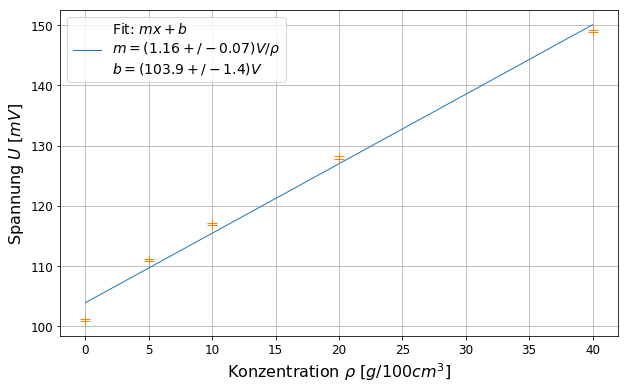

In [269]:
# diagramm konzentration

fig=plt.figure(figsize=fig_size)

xrange = np.linspace(0,40)
fitData = (xrange, gerade(xrange, *unv(fit_konz)))
plt.plot(*fitData, linewidth=1, label = 'Fit: $m x + b$\n$m = (%s)V/\\rho$\n$b = (%s)V$' % tuple(fit_konz))

(xdata, ydata) = konzentration
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1)

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Konzentration $\\rho$ [$g/100cm^3$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Spannung $U$ [$mV$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/konzentration.pdf")
plt.show()